In [1]:
import pandas as pds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
method_dict = {"vi": "D-CODE", "diff": "SR-T"}#, "spline": "SR-S", "gp": "SR-G"}

val_dict = {
    "noise": "sigma",
}

name_dict = {
    "GompertzODE-noise": " ",
    "GompertzODE_par_b-noise": "Parameter: $\theta_2$",
    "GompertzODE_par_ba-noise": "Parameters: a,b",
}

In [3]:
def plot_df(df, x_val="sigma"):
    for method in method_dict.keys():
        df_sub = df[df.method == method]
        df_sub = df_sub.dropna()

        plt.fill_between(
            df_sub[x_val],
            df_sub.rate - df_sub.rate_sd,
            df_sub.rate + df_sub.rate_sd,
            alpha=0.3,
        )

        plt.plot(df_sub[x_val], df_sub.rate, "o-", label=method_dict[method])
        plt.ylim(-0.05, 1.05)

In [4]:
def plot_df_ks(df, x_val="sigma"):
    for method in method_dict.keys():
        df_sub = df[df.method == method]
        df_sub = df_sub.dropna()

        plt.fill_between(
            df_sub[x_val],
            df_sub.ks - df_sub.ks_sd,
            df_sub.ks + df_sub.ks_sd,
            alpha=0.3,
        )

        plt.plot(df_sub[x_val], df_sub.ks, "o-", label=method_dict[method])
        plt.ylim(-0.05, 0.2)

Gompertz ODE:  

$\dot{x}(t) = - \theta_1 * x(t) * log(\theta_2 * x(t))$

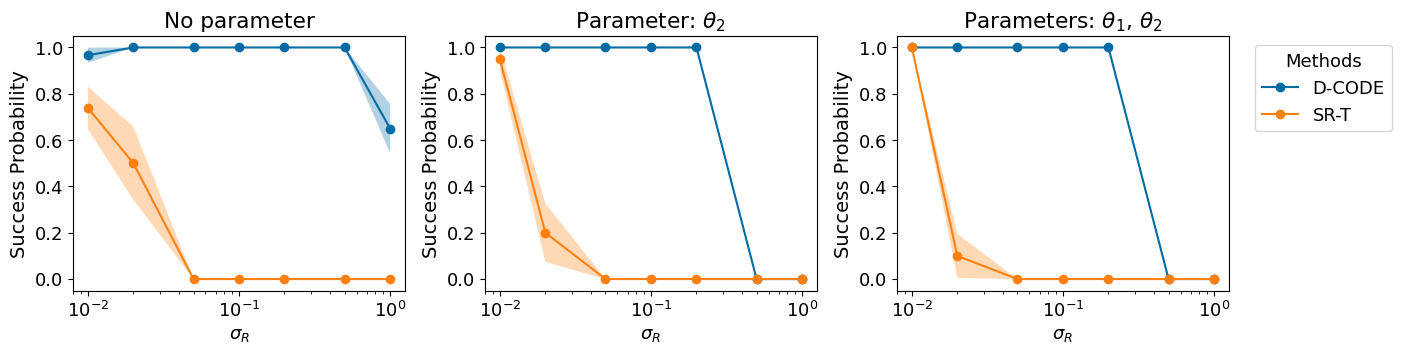

In [5]:
plt.figure(figsize=(14, 6))
plt.style.use("tableau-colorblind10")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rcParams["font.size"] = "13"

counter = 1
ode = "GompertzODE"
val_key = "noise"
x_val = val_dict[val_key]

for name1, name2 in name_dict.items():
    df = pds.read_csv("results/{}.txt".format(name1), header=None)
    #print(name1)

    df.columns = [
        "ode",
        "freq",
        "n",
        "sigma",
        "method",
        "rate",
        "rate_sd",
        "ks",
        "ks_sd",
    ]
    df["del_t"] = 1.0 / df["freq"]
    df = df.sort_values(["method", x_val])

    plot_conf = 230 + counter
    plt.subplot(plot_conf)
    plot_df(df, x_val=x_val)

    plt.xlabel(r"$\sigma_R$")
    plt.ylabel("Success Probability", size=14)
    #plt.title("{}".format(name2))
    plt.xscale("log")


    if counter == 1:
        plt.title(r"No parameter")
    elif counter == 2:
        plt.title(r"Parameter: $\theta_2$")
    elif counter == 3:
        plt.title(r"Parameters: $\theta_1$, $\theta_2$")

    counter += 1

plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout(pad=0.2)
plt.savefig("growth_results.png", dpi=200)

RMK. così come nel caso senza parametrizzazione, anche nei casi parametrizzati il risultato è sostanzialmente equivalente.  
Ciò che cambia sono i tempi di esecuzione, sensibilmente maggiori nel caso di più variabili, e la variabilità del risultato, minore nel caso paramterizzato in quanto ci sono meno costanti da stimare.

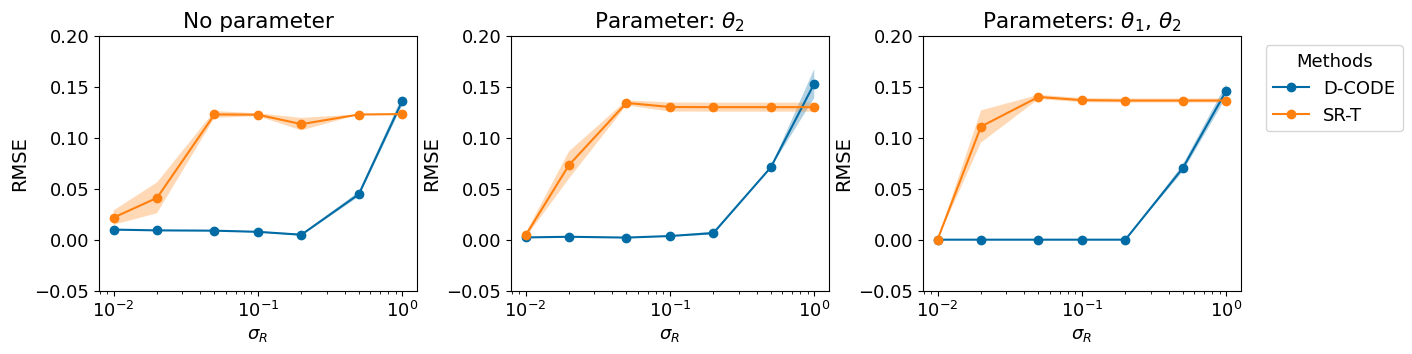

In [6]:
plt.figure(figsize=(14, 6))
plt.style.use("tableau-colorblind10")
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.rcParams["font.size"] = "13"

counter = 1
ode = "GompertzODE"
val_key = "noise"
x_val = val_dict[val_key]

for name1, name2 in name_dict.items():
    df = pds.read_csv("results/{}.txt".format(name1), header=None)
    #print(name1)

    df.columns = [
        "ode",
        "freq",
        "n",
        "sigma",
        "method",
        "rate",
        "rate_sd",
        "ks",
        "ks_sd",
    ]
    df["del_t"] = 1.0 / df["freq"]
    df = df.sort_values(["method", x_val])

    plot_conf = 230 + counter
    plt.subplot(plot_conf)
    plot_df_ks(df, x_val=x_val)

    plt.xlabel(r"$\sigma_R$")
    plt.ylabel("RMSE", size=14)
    #plt.title("{}".format(name2))
    plt.xscale("log")

    if counter == 1:
        plt.title(r"No parameter")
    elif counter == 2:
        plt.title(r"Parameter: $\theta_2$")
    elif counter == 3:
        plt.title(r"Parameters: $\theta_1$, $\theta_2$")


    counter += 1


plt.legend(title="Methods", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout(pad=0.2)
plt.savefig("growth_results.png", dpi=200)

RMK. A differenza di SR-T, che nel caso di alto rumore è del tutto incapace di avvicinarsi alla soluzione (ritornando equazione costante dopo poche generazioni), nel caso di D-CODE la SR viene portata avanti fino al termine delle generazioni (soprattutto nel caso noise=0.5), avvicinandosi molto alla forma funzionale corretta e spesso mancandola solo per una costante   
-> pur avendo anche D-CODE success probability nulla per noise>=0.5, la performance è molto migliore rispetto al caso SR, come si può osservare dall’RMSE (i plot non sono del tutto "veritieri")


Tempo per un'esecuzione:   

SR-T: 2m  
SR-T b: 3.5m  
SR-T ab: 3.2m
  
D-CODE: 1.8m  
D-CODE b: 3.3m  
D-CODE ab: 3.2m

RMK. Il codice che implementa D-CODE è semplicemente una modifica del codice che implementa la Symbolic Regression, usato per esempio da SR-T.  
Nel caso di D-CODE viene chiamata la classe SymbolicODE, che non è altro che la classe SymbolicRegressor implementata in gplearn, con una modifica nella funzione raw_fitness. Quest’ultima, anziché utilizzare la funzione fitness solita, implementa la loss variazionale specificata nel paper di D-CODE.  
Perciò sia SR-T che D-CODE identificano l’ODE tramite Symbolic Regression, ma con fitness functions diverse.


RMK. Il calcolo di raw_fitness in D-CODE non richiede un’integrazione numerica, ma solo calcoli semplici -> l’implementazione di D-CODE non aggiunge un overhead 				significativo nel calcolo del fitness value dei programmi  (che nel contesto della SR è l’operazione che richiede la maggior’parte di risorse computazionali)  
—> D-CODE ha un costo computazionale circa equivalente alla SR originale (in realtà è addirittura minoire (?))

TODO: Il fitness value calcolato in D-CODE non è esattamente quello riportato nel paper, capire in che modo sono equivalenti.